# Evaluating PIF as a privacy metric using differential privacy

In [1]:
import numpy as np
from pandas import DataFrame, Index, MultiIndex, RangeIndex, read_csv
from typing import cast, Mapping, NewType, Sequence, Text, Tuple

import klcalculator

In [2]:
Record = NewType('Record', Tuple[int, ...])
Dataset = NewType('Dataset', Mapping[Record, float])

## Utility functions

Acknowledgement: The functions in this section are derived from source code developed at Data61 by Arthur Street and Gianpaolo Gioiosa.

In [3]:
def encode_values_as_integers(raw_data: DataFrame, include_all_in_range: bool = False) -> DataFrame:
    data = raw_data.copy()
    for column_name in data.columns:
        if include_all_in_range:
            sorted_values = list(range(min(data[column_name]), max(data[column_name]) + 1))
        else:
            sorted_values = sorted({value for value in data[column_name]})
        value_dict = {value: i for i, value in enumerate(sorted_values)}
        data[column_name] = raw_data[column_name].map(value_dict)
    return data

In [4]:
def get_dataset_from_data(data: DataFrame) -> Dataset:
    maxima = data.agg('max')
    column_names = [column for column in data.columns]
    if len(column_names) > 1:
        index = MultiIndex.from_product([RangeIndex.from_range(range(maxima[column_name] + 1))
                                         for column_name in column_names], names=column_names)
    else:
        index = Index(range(maxima[column_names[0]] + 1), name=column_names[0])
    dataset_as_series = data.groupby(column_names).size().reindex(index=index, fill_value=0)
    d = dataset_as_series.to_dict()
    if len(column_names) == 1:
        d = {(k,): v for k, v in d.items()}
    dataset = cast(Dataset, d)
    return dataset

In [5]:
def as_data_frame(dataset: Dataset, feature_names: Sequence[Text], output_index_name: Text) -> DataFrame:
    index = MultiIndex.from_tuples(dataset.keys(), names=feature_names)
    return DataFrame.from_dict(cast(dict, dataset),
                               'index',
                               columns=[output_index_name]).reindex(index, fill_value=0)

## Read in the raw data

In [6]:
# data_path = '3_Trajectory/Inmate_Admissions.csv'
# feature_names = ['RACE', 'GENDER', 'INMATE_STATUS_CODE']
data_path = '1_PIF/our-synthetic.csv'
feature_names = ['gender', 'AGE', 'blood_group', 'eye_color']
number_of_records = 200
if number_of_records:
    raw_data = read_csv(data_path)[feature_names].iloc[:number_of_records, :]
else:
    raw_data = read_csv(data_path)[feature_names]
# raw_data = raw_data.fillna('Null')
raw_data.head(10)

,gender,AGE,blood_group,eye_color
0,F,99,B-,Brown
1,M,108,A-,Hazel
2,M,59,B+,Hazel
3,M,58,B+,Blue
4,M,30,AB-,Brown
5,M,6,A-,Grey
6,F,104,B+,Brown
7,M,11,AB-,Grey
8,F,105,A-,Green
9,M,115,A+,Grey


## Calculate PIF metrics for the unperturbed data

In [7]:
risks_for_records = klcalculator.find_risks_for_records(list(zip(*(raw_data[feature].tolist()
                                                                   for feature in feature_names))))
klcalculator.display_risks(feature_names, risks_for_records)

,gender,AGE,blood_group,eye_color
0,1.05889,4.20494,3.05889,2.59946
1,0.943416,5.14386,2.59946,2.55639
2,0.943416,4.08794,3.12029,1.33834
3,0.943416,6.64386,3.12029,2.4344
4,0.943416,4.85137,3.12029,2.59946
5,0.063613,4.48289,2.59946,2.12029
6,1.05889,5.35137,3.12029,2.59946
7,0.943416,4.19724,2.06015,2.12029
8,1.05889,4.00494,2.59946,2
9,0.943416,4.00494,2.94342,2.12029


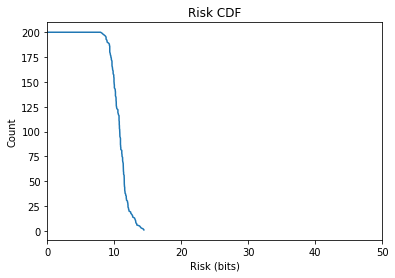

In [8]:
individual_risks = klcalculator.find_individual_risks(risks_for_records)
klcalculator.plot_individual_risk_cdf(individual_risks)

In [9]:
minimum_individual_risk = min(individual_risks)
maximum_individual_risk = max(individual_risks)
mean_individual_risk = np.mean(individual_risks)
individual_risks_tenth_percentile = klcalculator.percentile(individual_risks, 10)
individual_risks_fiftieth_percentile = klcalculator.percentile(individual_risks, 50)
individual_risks_ninety_fifth_percentile = klcalculator.percentile(individual_risks, 95)
print('Minimum: {0}'.format(minimum_individual_risk))
print('Maximum: {0}'.format(maximum_individual_risk))
print('Mean: {0}'.format(mean_individual_risk))
print('10th percentile: {0}'.format(individual_risks_tenth_percentile))
print('50th percentile: {0}'.format(individual_risks_fiftieth_percentile))
print('95th percentile: {0}'.format(individual_risks_ninety_fifth_percentile))

Minimum: 7.949526184581186
Maximum: 14.422506182962275
Mean: 10.822544566035281
10th percentile: 9.324741082732647
50th percentile: 10.807322660446815
95th percentile: 13.144673552909632


## Encode the raw data

In [10]:
data_encoded = encode_values_as_integers(raw_data=raw_data, include_all_in_range=False)
data_encoded.head(10)

,gender,AGE,blood_group,eye_color
0,0,81,5,1
1,1,90,1,4
2,1,47,4,4
3,1,46,4,0
4,1,27,3,1
5,1,6,1,3
6,0,86,4,1
7,1,10,3,3
8,0,87,1,2
9,1,96,0,3


## Represent the raw data as a histogram

In [11]:
dataset = get_dataset_from_data(data_encoded)
as_data_frame(dataset, feature_names, 'count').head(10)

count
gender AGE blood_group eye_color       
0      0   0           0              0
                       1              0
                       2              0
                       3              0
                       4              0
           1           0              0
                       1              0
                       2              0
                       3              0
                       4              0

## The Laplace mechanism

In [12]:
def apply_laplace_mechanism(dataset: Dataset, epsilon: float, sensitivity: float = 1.0):
    return cast(Dataset, dict((possible_record, np.random.laplace(loc=true_count, scale=sensitivity / epsilon))
                for possible_record, true_count in dataset.items()))

## Perturb the histogram with epsilon = log(2)

In [13]:
epsilon_1 = np.log(2)
perturbed_dataset_1 = apply_laplace_mechanism(dataset=dataset, epsilon=epsilon_1, sensitivity=1)
as_data_frame(perturbed_dataset_1, feature_names, 'count').head(10)

count
gender AGE blood_group eye_color          
0      0   0           0          0.780547
                       1         -1.039905
                       2          0.122277
                       3          0.332017
                       4         -4.269902
           1           0          4.464973
                       1         -0.437064
                       2          2.440215
                       3          1.054113
                       4          0.727709

## Perturb the histogram with epsilon = log(4)

In [14]:
epsilon_2 = np.log(4)
perturbed_dataset_2 = apply_laplace_mechanism(dataset=dataset, epsilon=epsilon_2, sensitivity=1)
as_data_frame(perturbed_dataset_2, feature_names, 'count').head(10)

count
gender AGE blood_group eye_color          
0      0   0           0         -0.020610
                       1          1.018012
                       2         -0.488080
                       3         -0.210757
                       4          0.124252
           1           0          0.634147
                       1         -0.039343
                       2         -0.211344
                       3          0.502173
                       4         -0.234145

## Calculate the privacy ratio based on differential privacy

In [15]:
privacy_ratio = np.exp(epsilon_2 - epsilon_1)
privacy_ratio

2.0

## Produce synthetic data

In [16]:
possible_records = [list(possible_record) for possible_record, count in dataset.items()]
number_of_samples = raw_data.shape[0]

In [17]:
counts_1 = [count if count >= 0 else 0 for possible_record, count in perturbed_dataset_1.items()]
probabilities_1 = [count / sum(counts_1) for count in counts_1]
probabilities_1 = [probability / sum(probabilities_1) for probability in probabilities_1]
synthetic_data_1 = DataFrame([possible_records[i] for i in
                              np.random.choice(len(possible_records), number_of_samples, p=probabilities_1)],
                             columns=feature_names)
synthetic_data_1.head(10)

,gender,AGE,blood_group,eye_color
0,1,33,4,1
1,1,41,4,3
2,1,87,6,1
3,0,87,2,1
4,0,43,5,1
5,0,90,1,0
6,0,6,5,2
7,1,18,7,3
8,0,14,5,4
9,0,56,0,2


In [18]:
counts_2 = [count if count >= 0 else 0 for possible_record, count in perturbed_dataset_2.items()]
probabilities_2 = [count / sum(counts_2) for count in counts_2]
probabilities_2 = [probability / sum(probabilities_2) for probability in probabilities_2]
synthetic_data_2 = DataFrame([possible_records[i] for i in
                              np.random.choice(len(possible_records), number_of_samples, p=probabilities_2)],
                             columns=feature_names)
synthetic_data_2.head(10)

,gender,AGE,blood_group,eye_color
0,0,21,7,1
1,1,66,6,1
2,1,82,4,2
3,1,39,4,2
4,0,41,4,4
5,1,41,2,0
6,0,79,1,4
7,1,92,3,4
8,1,61,6,4
9,1,41,5,2


## Calculate PIF metrics

In [19]:
risks_for_records_1 = klcalculator.find_risks_for_records(list(zip(*(synthetic_data_1[feature].tolist()
                                                                     for feature in feature_names))))
klcalculator.display_risks(feature_names, risks_for_records_1)

,gender,AGE,blood_group,eye_color
0,0.915936,4.39386,2.8365,2.05889
1,0.915936,4.72556,2.8365,2.4344
2,0.915936,3.72193,3.18442,2.05889
3,1.08927,5.14386,1.78673,1.1726
4,1.08927,4.66892,3.47393,2.05889
5,1.08927,4.33559,2.8365,2.8365
6,1.08927,4.86391,3.47393,2.2863
7,0.915936,5.24762,3,2.4344
8,1.08927,6.64386,3.47393,2.12029
9,1.08927,4.66892,2.68966,2.2863


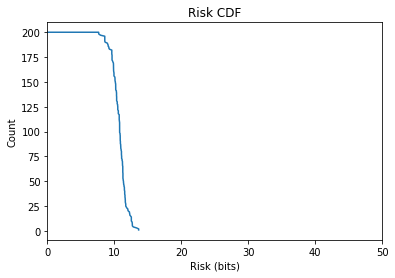

In [20]:
individual_risks_1 = klcalculator.find_individual_risks(risks_for_records_1)
klcalculator.plot_individual_risk_cdf(individual_risks_1)

In [21]:
risks_for_records_2 = klcalculator.find_risks_for_records(list(zip(*(synthetic_data_2[feature].tolist()
                                                                     for feature in feature_names))))
klcalculator.display_risks(feature_names, risks_for_records_2)

,gender,AGE,blood_group,eye_color
0,0.943416,4.86391,3,2.78588
1,1.05889,4.86391,2.64386,2.78588
2,1.05889,3.48794,2.24221,1.94342
3,1.05889,3.48794,2.68966,1.94342
4,0.943416,4.48289,2.68966,2.47393
5,1.05889,4.69041,2.19796,2.21759
6,0.943416,5.14386,3.39593,2.47393
7,1.05889,4.66892,2.88897,2.47393
8,1.05889,4.08794,2.64386,2.47393
9,1.05889,3.75917,3.05889,1.94342


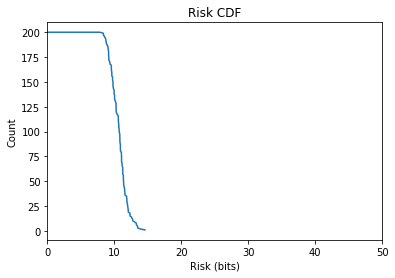

In [22]:
individual_risks_2 = klcalculator.find_individual_risks(risks_for_records_2)
klcalculator.plot_individual_risk_cdf(individual_risks_2)

In [23]:
minimum_individual_risk_1 = min(individual_risks_1)
maximum_individual_risk_1 = max(individual_risks_1)
mean_individual_risk_1 = np.mean(individual_risks_1)
individual_risks_tenth_percentile_1 = klcalculator.percentile(individual_risks_1, 10)
individual_risks_fiftieth_percentile_1 = klcalculator.percentile(individual_risks_1, 50)
individual_risks_ninety_fifth_percentile_1 = klcalculator.percentile(individual_risks_1, 95)
print('Minimum: {0}'.format(minimum_individual_risk_1))
print('Maximum: {0}'.format(maximum_individual_risk_1))
print('Mean: {0}'.format(mean_individual_risk_1))
print('10th percentile: {0}'.format(individual_risks_tenth_percentile_1))
print('50th percentile: {0}'.format(individual_risks_fiftieth_percentile_1))
print('95th percentile: {0}'.format(individual_risks_ninety_fifth_percentile_1))

Minimum: 7.665275483518503
Maximum: 13.641457540349997
Mean: 10.757423150045605
10th percentile: 9.628247134533066
50th percentile: 10.800485260291442
95th percentile: 12.543792999032696


In [24]:
minimum_individual_risk_2 = min(individual_risks_2)
maximum_individual_risk_2 = max(individual_risks_2)
mean_individual_risk_2 = np.mean(individual_risks_2)
individual_risks_tenth_percentile_2 = klcalculator.percentile(individual_risks_2, 10)
individual_risks_fiftieth_percentile_2 = klcalculator.percentile(individual_risks_2, 50)
individual_risks_ninety_fifth_percentile_2 = klcalculator.percentile(individual_risks_2, 95)
print('Minimum: {0}'.format(minimum_individual_risk_2))
print('Maximum: {0}'.format(maximum_individual_risk_2))
print('Mean: {0}'.format(mean_individual_risk_2))
print('10th percentile: {0}'.format(individual_risks_tenth_percentile_2))
print('50th percentile: {0}'.format(individual_risks_fiftieth_percentile_2))
print('95th percentile: {0}'.format(individual_risks_ninety_fifth_percentile_2))

Minimum: 7.849601173872605
Maximum: 14.572609743491842
Mean: 10.676089961519097
10th percentile: 9.148877324763435
50th percentile: 10.733524790074185
95th percentile: 12.7390524900349


## Calculate privacy ratios based on PIF

In [25]:
minimum_individual_risk_ratio = minimum_individual_risk_1 / minimum_individual_risk_2
maximum_individual_risk_ratio = maximum_individual_risk_1 / maximum_individual_risk_2
mean_individual_risk_ratio = mean_individual_risk_1 / mean_individual_risk_2
individual_risks_tenth_percentile_ratio = individual_risks_tenth_percentile_1 / individual_risks_tenth_percentile_2
individual_risks_fiftieth_percentile_ratio = individual_risks_fiftieth_percentile_1 / individual_risks_fiftieth_percentile_2
individual_risks_ninety_fifth_percentile_ratio = individual_risks_ninety_fifth_percentile_1 / individual_risks_ninety_fifth_percentile_2
print('Ratio of minima: {0}'.format(minimum_individual_risk_ratio))
print('Ratio of maxima: {0}'.format(maximum_individual_risk_ratio))
print('Ratio of means: {0}'.format(mean_individual_risk_ratio))
print('Ratio of 10th percentiles: {0}'.format(individual_risks_tenth_percentile_ratio))
print('Ratio of 50th percentiles: {0}'.format(individual_risks_fiftieth_percentile_ratio))
print('Ratio of 95th percentiles: {0}'.format(individual_risks_ninety_fifth_percentile_ratio))

Ratio of minima: 0.9765178273047005
Ratio of maxima: 0.9361025774015735
Ratio of means: 1.0076182561986333
Ratio of 10th percentiles: 1.0523965720331732
Ratio of 50th percentiles: 1.0062384418470975
Ratio of 95th percentiles: 0.9846723693810866
